<a href="https://colab.research.google.com/github/Thammawit/Dataset1/blob/master/Autoregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoregression for Time Series Forecasting**
**Prepared by: Thammawit Prasert**

Created: February 21, 2022

Autoregression is a linear regression model that uses lagged variables as inputs to predict the value at the next time step. Example:

*   yhat = a0 + a1 * X1
*   yhat = b0 + b1 X(t-1) + b2 X(t-2)

In this tutorial, we will use AR model to perform 24-hour prediction. AR model automatically choses optimal lagged values for prediction.

**Note:** Look back forecasting is a special type of autoregression model.

# **1. Load data**
Similar to the lookback example, this notebook will work with "Bangkok.csv", the electrical consumption of a building at one-hour intervals for one year.

In [ ]:
# We will use the following Python libraries: Pandas, Numpy and Matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
url ='https://raw.githubusercontent.com/Thammawit/Dataset1/master/Bangkok.csv'
df = pd.read_csv(url, index_col=[0], parse_dates=[0])[['Load']]
df.head()
#We will parse the first column (col=[0]) as the index column as the date. 
#The 'Load' column will be saved in the dataframe df.
#Note: the 'Load' is in kilo-Watt (kW).

,Load
Time,
2016-01-01 00:00:00,4.30
2016-01-01 01:00:00,4.12
2016-01-01 02:00:00,4.06
2016-01-01 03:00:00,4.44
2016-01-01 04:00:00,3.88


# **2. Data Exploration**
Let us now visualize the data.

In [ ]:
df1 = pd.concat([df.shift(4), df.shift(3), df.shift(2), df.shift(1), df], axis=1)
df1.columns = ['Lt-4','Lt-3','Lt-2','Lt-1', 'Lt']
df1.dropna(axis = 0, inplace=True) #ลบบรรทัดที่มี NaN
df1.head()

,Lt-4,Lt-3,Lt-2,Lt-1,Lt
Time,,,,,
2016-01-01 04:00:00,4.30,4.12,4.06,4.44,3.88
2016-01-01 05:00:00,4.12,4.06,4.44,3.88,5.62
2016-01-01 06:00:00,4.06,4.44,3.88,5.62,3.50
2016-01-01 07:00:00,4.44,3.88,5.62,3.50,3.06
2016-01-01 08:00:00,3.88,5.62,3.50,3.06,1.38


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


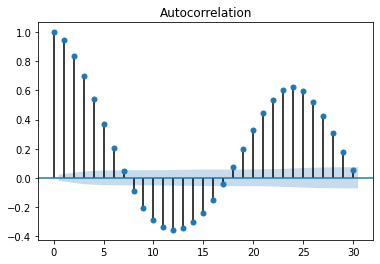

In [ ]:
#We can also visualize autocorrelation using statsmodels library
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df, lags=30)
plt.show()

# **3. Autoregression Model**
To create the AR model, we create the model AR(). Then, we call fit() to train it on the dataset.

## **(a) Use AR for 1-hour ahead forecasting**

In [ ]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error  #หรือจะทำแบบ manual ก็ได้

X = df['Load'].values
X

array([4.3 , 4.12, 4.06, ..., 3.5 , 3.5 , 3.88])

In [ ]:
#here we will use AR to do 1-hour ahead forecasting
#training data = hourly data 90-day prior to the "hour"
#testing data = the next hour
hour=330*24
train = X[hour-(90*24):hour] 
test  = X[hour:hour+1]

In [ ]:
print(len(train), len(test))

2160 1


In [ ]:
# AR automatically chooses optimal lag values
model = AR(train)
model_fit = model.fit()
# The list of coefficients is then printed in the trained linear regression model.
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 26
Coefficients: [ 1.55049256  1.28833781 -0.3893299   0.05971361 -0.06574449 -0.00569287
  0.10025937 -0.09431402 -0.06328383  0.01773538  0.02782225  0.04195767
 -0.03712627  0.00498041 -0.01739798  0.03086962 -0.04485155  0.05030196
 -0.07243475  0.01914442  0.00629644  0.06084334 -0.0087184   0.08986592
  0.10685083 -0.17187119 -0.01723198]


In [ ]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
for i in range(len(predictions)):
 	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
RMSE = np.sqrt(np.mean(np.square(test.ravel(), predictions)))
print('Test RMSE: %.3f' % RMSE)

predicted=9.060506, expected=6.750000
Test RMSE: 6.750


## **(b) Continuous 1-hour ahead forecasting**

In this example, we will crate an AR model that performs hour-ahead load forecasting. The training data are all the data available up to the current hour. The testing data are each one hour of the last two months of data.

Note: the amount of historical data used as inputs can be adjusted accordingly. For example, to use only 90 days of data as input:

*   train = X[1+hour-24*90:hour]

This will help increase the speed of prediction.

In [ ]:
from statsmodels.tsa.ar_model import AR

X = df['Load'].values
predict=[]
test1=[]

for hour in np.arange(293*24, 366*24):
  #create train and test data
  train = X[hour-(24*90):hour]
  test  = X[hour:hour+1]
  
  #create and fit the model
  model = AR(train)
  model_fit = model.fit()
  
  #make predictions
  predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
  RMSE = np.sqrt(np.mean(np.square(test.ravel()-predictions)))
  print('Hour:',hour, 'Lag:', model_fit.k_ar, 'RMSE:', RMSE)

  #create the predicted/test arrays
  predict = np.concatenate((predict, predictions))
  test1 = np.concatenate((test1, test.ravel()))

overallRMSE = np.sqrt(np.mean(np.square(test1-predict)))
overallMAPE = np.mean(np.abs((test1-predict)/test1))*100

print('Overall RMSE: %.3f' %overallRMSE)
print('Overall MAPE: %.3f' %overallMAPE)

Hour: 7032 Lag: 26 RMSE: 0.9743759812572081
Hour: 7033 Lag: 26 RMSE: 0.5572208671910905
Hour: 7034 Lag: 26 RMSE: 0.5688483283721038
Hour: 7035 Lag: 26 RMSE: 2.169992348431136
Hour: 7036 Lag: 26 RMSE: 0.9502954879150183
Hour: 7037 Lag: 26 RMSE: 0.7704968199580238
Hour: 7038 Lag: 26 RMSE: 3.1901904261098952
Hour: 7039 Lag: 26 RMSE: 7.104651302076817
Hour: 7040 Lag: 26 RMSE: 0.4850321215369604
Hour: 7041 Lag: 26 RMSE: 2.11469615996549
Hour: 7042 Lag: 26 RMSE: 7.208451760106058
Hour: 7043 Lag: 26 RMSE: 1.6865295261785036
Hour: 7044 Lag: 26 RMSE: 0.8634370639009887
Hour: 7045 Lag: 26 RMSE: 4.415664791025421
Hour: 7046 Lag: 26 RMSE: 1.093859764136333
Hour: 7047 Lag: 26 RMSE: 3.4233688541263447
Hour: 7048 Lag: 26 RMSE: 7.158715060698462
Hour: 7049 Lag: 26 RMSE: 2.260570478579936
Hour: 7050 Lag: 26 RMSE: 2.611250761114615
Hour: 7051 Lag: 26 RMSE: 5.147019077905739
Hour: 7052 Lag: 26 RMSE: 1.8336030242229784
Hour: 7053 Lag: 26 RMSE: 0.05752012279643459
Hour: 7054 Lag: 26 RMSE: 0.869219606111309

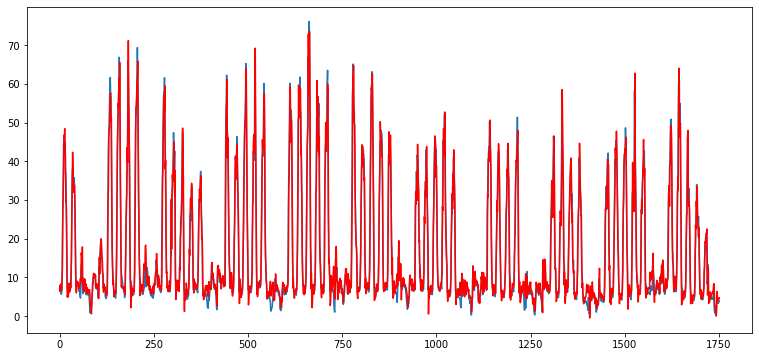

In [ ]:
# plot results
plt.figure(figsize=(13,6))
plt.plot(test1)
plt.plot(predict, color='red')
plt.show()

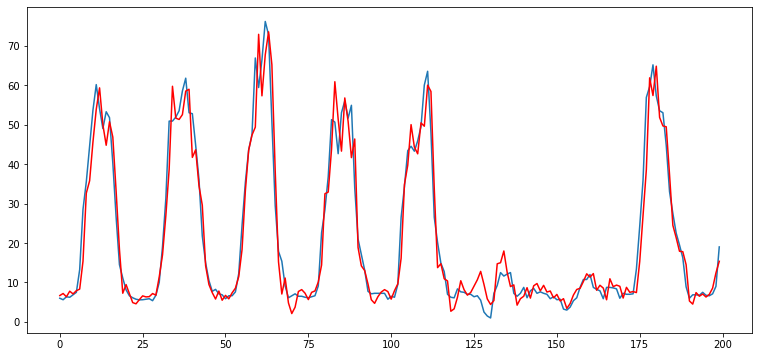

In [ ]:
# plot results
plt.figure(figsize=(13,6))
plt.plot(test1[600:800])
plt.plot(predict[600:800], color='red')
plt.show()

# **Further reading:**



*   Machinelearningmastery: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
